---

# Маркетинговой аналитики Яндекс.Афиши

## Описание проекта

Маркетинговая аналитика Яндекс.Афиши. 

Есть данные Яндекс.Афиши с июня 2017 по конец мая 2018 года:
    - лог сервера с данными о посещениях сайта Яндекс.Афиши,
    - выгрузка всех заказов за этот период,
    - статистика рекламных расходов.
    
Необходимо проанализировать:
    - как клиенты пользуются сервисом,
    - когда делают первые покупки на сайте,
    - сколько денег приносит компании каждый клиент,
    - когда расходы на привлечение клиента окупаются.
    
Цель - снизить расходы, избавиться от невыходных источников трафика.

## Описание данных

Структура visits_log.csv

    * Uid — уникальный идентификатор пользователя,
    * Device — категория устройства пользователя,
    * Start Ts — дата и время начала сессии,
    * End Ts — дата и время окончания сессии,
    * Source Id — идентификатор источника перехода на сайт.
    
Структура orders_log.csv

    * Uid — уникальный идентификатор пользователя,
    * Buy Ts — дата и время заказа,
    * Revenue — сумма заказа.
    
Структура costs.csv

    * source_id — идентификатор рекламного источника,
    * dt — дата проведения рекламной кампании,
    * costs — расходы на эту кампанию.

## План выполнения

1. [Загрузка данных и подготовка их к анализу](#step_1); <a id='step_1'></a>
2. [Расчёт продуктовых метрик](#step_2);
3. [Расчёт метрик электронной коммерции](#step_3);
4. [Расчёт маркетинговых метрик](#step_4);
5. [Общие выводы и рекомендации](#step_5).

### Загрузка данных и подготовка их к анализу

In [1]:
# Импортирование необходимых библиотек
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import math
import seaborn as sns

Данные о визитах пользователей<a id='step_1'></a>

In [2]:
visits_data = pd.read_csv('')
visits_data.info()
visits_data.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387
6,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451
7,touch,2017-11-05 15:15:00,3,2017-11-05 15:14:00,11423865690854540312
8,desktop,2017-07-19 10:44:00,3,2017-07-19 10:41:00,2987360259350925644
9,desktop,2017-11-08 13:43:00,5,2017-11-08 13:42:00,1289240080042562063


В данных с визитами пользователей на сайт нет пропусков. 5 столбцов, два из них имеют неправильный тип данных: 'End Ts' и 'End Ts'. Их надо привести к типу данных, соответствующему времени. Также приведём названия столбцов к нижнему регистру.

In [3]:
# Приведение названий столбцов к нижнему регистру
columns_list_1 = visits_data.columns.str.lower()
visits_data.columns = ['device', 'end_ts', 'source_id', 'start_ts', 'uid']
visits_data.columns

Index(['device', 'end_ts', 'source_id', 'start_ts', 'uid'], dtype='object')

In [4]:
# Приведение столбцов с татамик типу datetime
visits_data['end_ts'] = pd.to_datetime(visits_data['end_ts'], format='%Y-%m-%d %H:%M:%S')
visits_data['start_ts'] = pd.to_datetime(visits_data['start_ts'], format='%Y-%m-%d %H:%M:%S')

Данные о покупках пользователей

In [5]:
orders_data = pd.read_csv('')
orders_data.info()
orders_data.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450
5,2017-06-01 08:43:00,0.18,10402394430196413321
6,2017-06-01 08:54:00,1.83,12464626743129688638
7,2017-06-01 09:22:00,1.22,3644482766749211722
8,2017-06-01 09:22:00,3.30,17542070709969841479
9,2017-06-01 09:23:00,0.37,1074355127080856382


В данных с покупками пользователей на сайте нет пропусков. 3 столбца, один из них имеет неправильный тип данных: 'Buy Ts'. Этот столбец надо привести к типу данных, соответствующему времени.Также приведём названия столбцов к нижнему регистру.

In [6]:
# Приведение названий столбцов к нижнему регистру
columns_list_2 = orders_data.columns.str.lower()
orders_data.columns = ['buy_ts', 'revenue', 'uid']
orders_data.columns

Index(['buy_ts', 'revenue', 'uid'], dtype='object')

In [7]:
# Приведение столбцов с татамик типу datetime
orders_data['buy_ts'] = pd.to_datetime(orders_data['buy_ts'], format='%Y-%m-%d %H:%M:%S')

Данные о рекламных кампаниях

In [8]:
costs_data = pd.read_csv('')
costs_data.info()
costs_data.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08
5,1,2017-06-06,40.39
6,1,2017-06-07,40.59
7,1,2017-06-08,56.63
8,1,2017-06-09,40.16
9,1,2017-06-10,43.24


В данных с покупками пользователей на сайте нет пропусков. 3 столбца, один из них имеет неправильный тип данных: 'dt'. Этот столбец надо привести к типу данных, соответствующему времени.

In [9]:
# Приведение столбцов с татамик типу datetime
costs_data['dt'] = pd.to_datetime(costs_data['dt'], format='%Y-%m-%d %H:%M:%S')

Отфильтруем визиты и заказы, совершённые после интересующей нас даты.

In [10]:
orders_data = orders_data[(orders_data['buy_ts'] < '2018-06-01')] 
visits_data = visits_data[(visits_data['start_ts'] < '2018-06-01') & (visits_data['end_ts'] < '2018-06-01')] 

### Расчёт продуктовых метрик

<a id='step_2'></a>

In [11]:
# выделили год, месяц, неделю и день начала сессии 
visits_data['session_year']  = visits_data['start_ts'].dt.year
visits_data['session_month'] = visits_data['start_ts'].dt.month
visits_data['session_week']  = visits_data['start_ts'].dt.week
visits_data['session_date'] = visits_data['start_ts'].dt.date

In [12]:
visits_data['session_year']  = visits_data['start_ts'].astype('datetime64[Y]')
visits_data['session_month'] = visits_data['start_ts'].astype('datetime64[M]')
visits_data['session_week']  = visits_data['start_ts'].astype('datetime64[W]')
visits_data['session_date'] = visits_data['start_ts'].astype('datetime64[D]')

DAU - количество уникальных пользователей в день. <a id='step_22'></a>

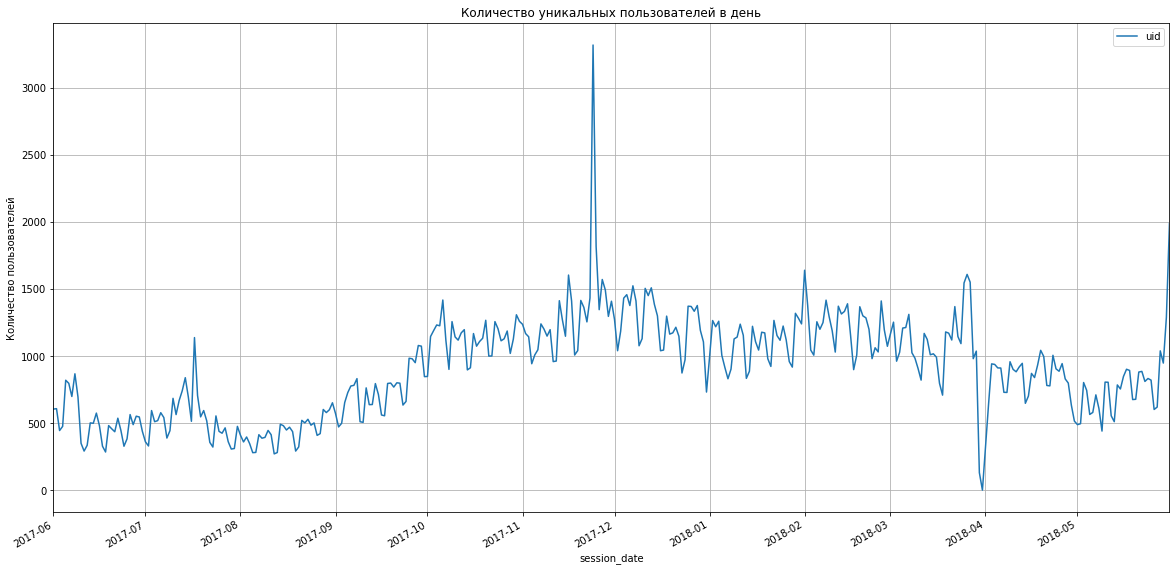

In [13]:
# Расчёт dau
dau = visits_data.groupby('session_date').agg({'uid': 'nunique'})
dau_plot = dau.plot(legend=True, title='Количество уникальных пользователей в день', figsize=(20,10), grid=True )
dau_plot.set_ylabel('Количество пользователей')
plt.show()

В течение года тенденции посещения сайта не сильно отличаются: явно видна зависимость от дня недели, люди строят планы на выходные. Явно виден выброс в декабре. 

WAU (от англ. weekly active users) — количество уникальных пользователей в неделю.

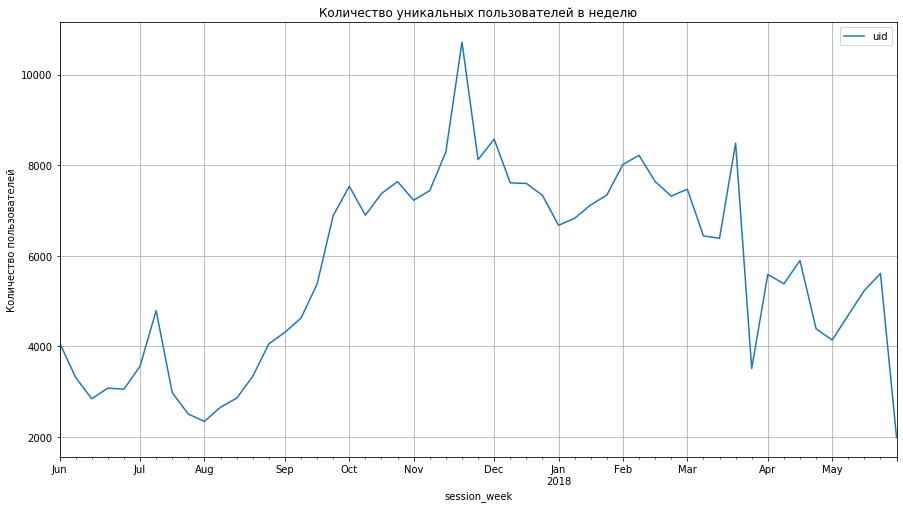

In [14]:
# Расчёт wau
wau = visits_data.groupby('session_week').agg({'uid': 'nunique'})
wau_plot = wau.plot(legend=True, title='Количество уникальных пользователей в неделю', figsize=(15,8), grid=True)
wau_plot.set_ylabel('Количество пользователей')
plt.show()

На графике уникальных пользователей в неделю видна явная просадка в середине года. Летом люди могут больше времени проводить просто гуляя или выезжая на природу.

MAU (от англ. monthly active users) — количество уникальных пользователей в месяц.

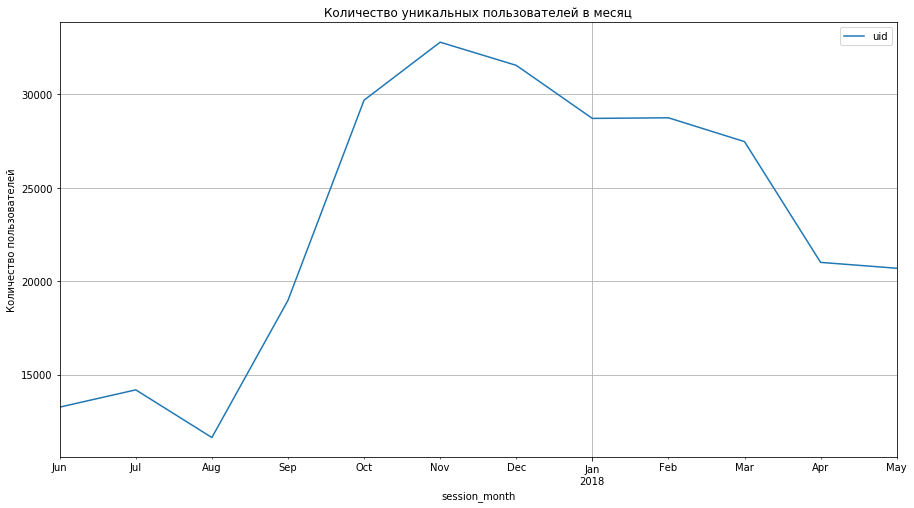

In [15]:
# Расчёт mau
mau = visits_data.groupby('session_month').agg({'uid': 'nunique'})
mau_plot = mau.plot(legend=True, title='Количество уникальных пользователей в месяц', figsize=(15,8), grid=True)
mau_plot.set_ylabel('Количество пользователей')
plt.show()

График распределения уникальных пользователей по месяцам похож на график с неделями. Такая же просадка в летние месяцы по посещениям сайта.

In [16]:
# Расчёт средних значений
dau_total = visits_data.groupby('session_date').agg({'uid': 'nunique'}).mean()
mau_total = visits_data.groupby(['session_year', 'session_month']).agg({'uid':'nunique'}).mean()
wau_total = visits_data.groupby(['session_year', 'session_week']).agg({'uid':'nunique'}).mean()
print('Среднее количество уникальных пользователей в день:',dau_total)
print('Среднее количество уникальных пользователей в неделю:',wau_total)
print('Среднее количество уникальных пользователей в месяц:',mau_total )

Среднее количество уникальных пользователей в день: uid    907.967033
dtype: float64
Среднее количество уникальных пользователей в неделю: uid    5621.537037
dtype: float64
Среднее количество уникальных пользователей в месяц: uid    23227.833333
dtype: float64


Посещения сайта в день

In [17]:
# Группировка данных о визитах по дню и подсчёт визитов и уникальных пользователей
sessions_per_user = visits_data.groupby(['session_year', 'session_month','session_date']).agg({'uid': ['count', 'nunique']})

In [18]:
# Изменение названий стобцов с количеством сессий и количеством пользователей.
sessions_per_user.columns = ['n_sessions', 'n_users']

In [19]:
sessions_per_user = sessions_per_user.reset_index()

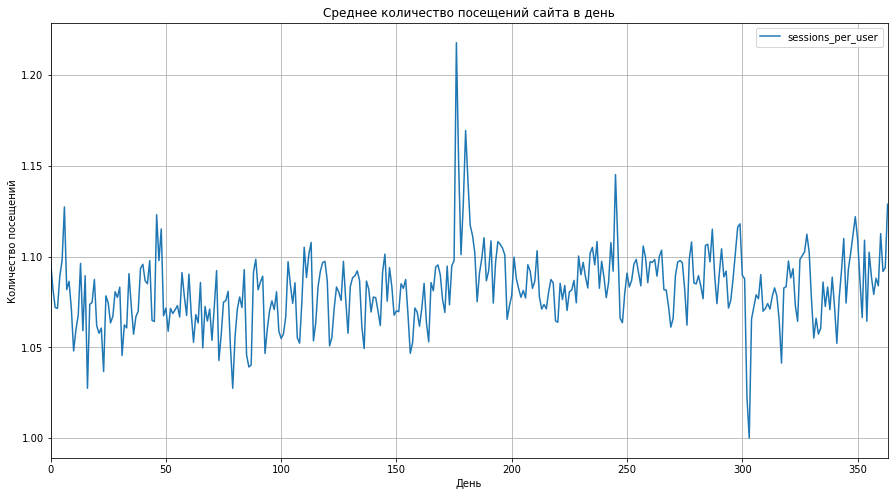

In [20]:
# Среднее количество посещений за день
sessions_per_user['sessions_per_user'] = (sessions_per_user['n_sessions'] / sessions_per_user['n_users'])
spu_plot = sessions_per_user['sessions_per_user'].plot(legend=True, title='Среднее количество посещений сайта в день', 
                                            figsize=(15,8), grid=True)
spu_plot.set_ylabel('Количество посещений')
spu_plot.set_xlabel('День')
plt.show()

Поведение этого графика похоже на поведение графика [DAU](#step_22). В течение недели люди по разному заходят на сайт. И всё ещё есть наиболее популярный день в году с популярным мероприятием. Люди заходят на сайт около 1 раза в день.

ASL (англ. average session length) показывает, сколько длится сессия пользователя в среднем.

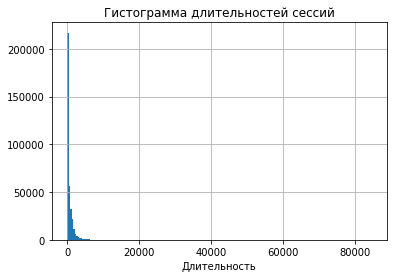

In [21]:
# Рсчёт длительности одного опсещения ASL.
visits_data['session_duration_sec'] = (visits_data['end_ts'] - visits_data['start_ts']).dt.seconds
dur_hist = visits_data['session_duration_sec'].hist(bins=200)
plt.title('Гистограмма длительностей сессий')
dur_hist.set_xlabel('Длительность')
plt.show()

Распределение не похоже на нормальное, поэтому мы не можем восспользоваться средним или медианным значением.
Поэтому для определения типичной длительности сессии используем моду.

In [22]:
print('Длительность типичной сессии в секундах: ',visits_data['session_duration_sec'].mode())

Длительность типичной сессии в секундах:  0    60
dtype: int64


Расчёт Retention Rate

Retention Rate показывает, сколько пользователей из когорты относительно их изначального числа вернулось в последующие периоды.

In [23]:
# Определили первые посещения сайта пользователями.
first_visit_date_by_cust = visits_data.groupby('uid')['start_ts'].min()
first_visit_date_by_cust.name = 'first_visit_date'

In [24]:
visits_data = visits_data.join(first_visit_date_by_cust, on='uid')

In [25]:
# Определили месяц первого посещения и месяца посещений всех.
visits_data['first_visit_month'] = visits_data['first_visit_date'].astype('datetime64[M]')
visits_data['visit_month'] = visits_data['start_ts'].astype('datetime64[M]')

In [26]:
# Длительность "жизни" когорты в месяцах
visits_data['cohort_lifetime'] = (visits_data['visit_month'] - visits_data['first_visit_month']) / np.timedelta64(1, 'M')
visits_data['cohort_lifetime'] = visits_data['cohort_lifetime'].round().astype('int')

In [27]:
# Определение когорт
cohorts = visits_data.groupby(['first_visit_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()

In [28]:
# Количество пользователей в 0-ой месяц
initial_customers = cohorts[cohorts['cohort_lifetime'] == 0][['first_visit_month', 'uid']]

In [29]:
initial_customers = initial_customers.rename(columns={'uid':'cohort_customers'})

In [30]:
cohorts = cohorts.merge(initial_customers,on='first_visit_month') 

In [31]:
# Retention Rate
cohorts['retention'] = cohorts['uid']/cohorts['cohort_customers']

In [32]:
retention_pivot = cohorts.pivot_table(
                                        index='first_visit_month',
                                        columns='cohort_lifetime',
                                        values='retention',
                                        aggfunc='sum',
                                    ) 

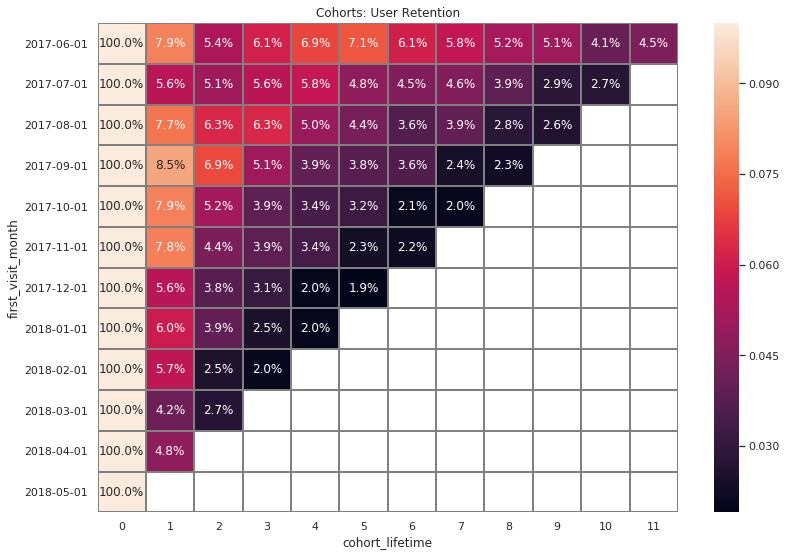

In [33]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention')
retention_pivot.index = retention_pivot.index.astype('str')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1,vmax = 0.1, linecolor='gray'); 

На тепловой диаграмме мы видим, что с течением времени отток пользователей усиливается. Первая когорта самая стойкая. 

In [34]:
retention_pivot_2 = retention_pivot[[2]]

In [35]:
retention_2 = retention_pivot_2[[2]].mean()
print('Cредний Retention Rate на второй месяц «жизни» когорт:',retention_2)

Cредний Retention Rate на второй месяц «жизни» когорт: cohort_lifetime
2    0.046333
dtype: float64



После анализа посещаймости сайта по дням, неделям и месяцам можно сделать следующие выводы: 
        
    - посещаемость зависит от дня недели;
    - к лету посещаемость сайта падает;
    - с прошлого года уровень посещаемость сайта увеличился;
    - декабрь наиболее популярный месяц.
    
На сайте люди проводят в среднем минуту. За это время можно найти конкретное мероприятие, но на случайный сёрфинг по сайту это не похоже. 

Когорта июня 2017 года самая первая и самая стойкая. Когорты, появившиеся в пик активности (декабрь-январь), быстрее всего угасают.


### Расчёт метрик электронной коммерции

Время между первым визитом и первой покупкой <a id='step_3'></a>

In [36]:
# Определили дату первой покупки
first_order_date_by_cust = orders_data.groupby('uid')['buy_ts'].min()
first_order_date_by_cust.name = 'first_order_date'

In [37]:
orders_data = orders_data.join(first_order_date_by_cust, on='uid')

In [38]:
visits_orders = visits_data[['uid','first_visit_date']].merge(orders_data[['uid','first_order_date']], on = 'uid')

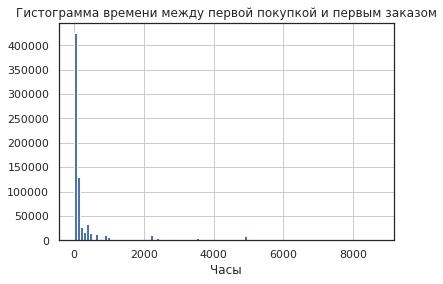

In [39]:
# Рассчитали время между первой покупкой и первым визитом на сайт
visits_orders['time_between'] = (visits_orders['first_order_date'] - visits_orders['first_visit_date']) /np.timedelta64(1, 'h')
time_hist = visits_orders['time_between'].hist(bins = 100)
plt.title('Гистограмма времени между первой покупкой и первым заказом')
time_hist.set_xlabel('Часы')
plt.show()

In [40]:
time_visit_order_median = visits_orders['time_between'].median()
print('Среднее время между первым визитом и заказом =',time_visit_order_median.round(2))

Среднее время между первым визитом и заказом = 47.82


Пользователю нужно около двух дней, чтобы сделать заказ после визита. Большое число более решительных пользователей, кто в тот же день делает заказ. Есть выбросы среди тех, кто делает заказ сильно после своего первого визита на сайт.

Среднее количество покупок на одного покупателя за определённый период.

In [41]:
# Выделили месяц первого заказа и всех заказов
orders_data['order_month'] = orders_data['buy_ts'].astype('datetime64[M]')
orders_data['first_order_month'] = orders_data['first_order_date'].astype('datetime64[M]')

In [42]:
# Подсчитали количество заказов и количество пользователей по когортам и по месяцам
orders_grouped_by_cohorts = orders_data.groupby(['first_order_month', 'order_month']).agg({'buy_ts': 'count', 'uid': 'nunique'})
print(orders_grouped_by_cohorts.head()) 

                               buy_ts   uid
first_order_month order_month              
2017-06-01        2017-06-01     2354  2023
                  2017-07-01      177    61
                  2017-08-01      174    50
                  2017-09-01      226    54
                  2017-10-01      292    88


In [43]:
# Количество заказов на пользователя
orders_grouped_by_cohorts['orders_per_cust'] = (orders_grouped_by_cohorts['buy_ts'] / orders_grouped_by_cohorts['uid'])

In [44]:
orders_grouped_by_cohorts = orders_grouped_by_cohorts.reset_index()
orders_grouped_by_cohorts['cohort_lifetime'] = (orders_grouped_by_cohorts['order_month']
                                                - orders_grouped_by_cohorts['first_order_month'])


In [45]:
orders_grouped_by_cohorts['cohort_lifetime'] = (orders_grouped_by_cohorts['cohort_lifetime'] / np.timedelta64(1, 'M')).round().astype('int')

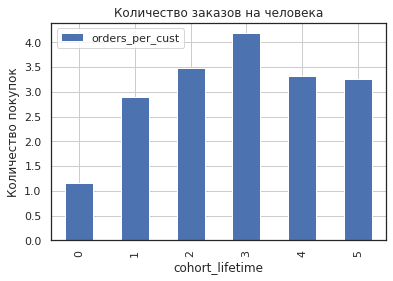

In [46]:
lifetime_pivot = orders_grouped_by_cohorts.pivot_table( index = 'first_order_month',
                                                            columns='cohort_lifetime',
                                                            values='orders_per_cust',
                                                            aggfunc='cumsum')
lifetime_6_plot = lifetime_pivot.query('index < 6').plot(kind = 'bar', legend = True, grid = True, 
                                                         title = 'Количество заказов на человека')
lifetime_6_plot.set_xlabel('cohort_lifetime')
lifetime_6_plot.set_ylabel('Количество покупок')
plt.show()

В первый месяц люди делают один заказ в среднем. Дальше количество заказов увеличивается до трёх. Это значит, что пользователям нравится продукт и они продолжают покупать билеты через него.

Средний чек

In [47]:
# расчёт средней выручки по месяцам
revenue_by_months = orders_data.groupby('order_month')['revenue'].mean()

In [48]:
# Функция для приведения даты на графике к удобному виду
def line_format(label):
    """
    Convert time label to the format of pandas line plot
    """
    month = label.month_name()[:3]
    if month == 'Jan':
        month += f'\n{label.year}'
    return month

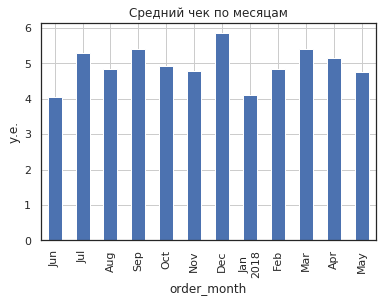

In [49]:
plot_rev = revenue_by_months.plot(kind='bar', legend = False, grid=True, 
                        title='Средний чек по месяцам', stacked=True)
plot_rev.set_xticklabels(map(line_format, revenue_by_months.index))
plot_rev.set_ylabel('у.е.')
plt.show()

Есть месяца, когда средний чек увеличивается - декабрь, июль, сентябрь, март. Месяца аутсайдеры - июнь и январь.

Расчёт LTV

LTV (от англ. lifetime value) — «пожизненная» ценность клиента. Это — итоговая сумма денег, которую один клиент приносит в среднем со всех своих покупок.

In [50]:
# Определили размер когорт
cohort_sizes = (
    orders_data.groupby('first_order_month')
    .agg({'uid': 'nunique'})
    .reset_index()
)
cohort_sizes.columns = ['first_order_month', 'n_buyers']
print(cohort_sizes.head()) 

  first_order_month  n_buyers
0        2017-06-01      2023
1        2017-07-01      1923
2        2017-08-01      1370
3        2017-09-01      2581
4        2017-10-01      4340


In [51]:
# Суммарная прибыль по когортам 
cohorts = (
    orders_data.groupby(['first_order_month', 'order_month'])
                    .agg({'revenue': 'sum'})
                    .reset_index())
print(cohorts.head()) 

  first_order_month order_month  revenue
0        2017-06-01  2017-06-01  9557.49
1        2017-06-01  2017-07-01   981.82
2        2017-06-01  2017-08-01   885.34
3        2017-06-01  2017-09-01  1931.30
4        2017-06-01  2017-10-01  2068.58


In [52]:
report_ltv = pd.merge(cohort_sizes, cohorts, on='first_order_month')

In [53]:
margin_rate = 1

report_ltv['gp'] = report_ltv['revenue'] * margin_rate   # валовая прибыль
report_ltv['age'] = (report_ltv['order_month'] - report_ltv['first_order_month']) / np.timedelta64(1, 'M')
report_ltv['age'] = report_ltv['age'].round().astype('int')  # возраст когорты


In [54]:
# Расчёт ltv
report_ltv['ltv'] = report_ltv['gp'] / report_ltv['n_buyers']

output_ltv = report_ltv.pivot_table(
    index='first_order_month', columns='age', values='ltv', aggfunc='mean')

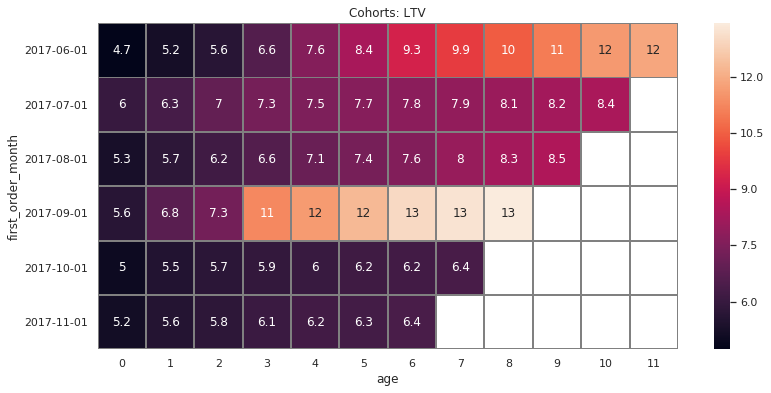

In [55]:
# Ограничение на возраст когорт
output_6_months = (output_ltv.loc['2017-06-01':'2017-11-01'])

sns.set(style='white')
plt.figure(figsize=(13, 6))
plt.title('Cohorts: LTV')
output_6_months.index = output_6_months.index.astype('str')
sns.heatmap(output_6_months.cumsum(axis=1), annot=True,  linewidths=1, linecolor='gray'); 

Есть наиболее удачные когорты, т.е. они за время своего существования принесли больше прибыли, чем остальные. Возможно, это связано с мероприятиями в первый месяц покупки. Или резкое увеличение LVT связано с увеличением среднего чека на мероприятия в декабре месяце.

---

В среднем посетители делают один заказ в месяц. Но те, кто остаются с продуктом за полгода делают больше 3-х заказов. 
Когорта июня 2017 самая стабильная, она не приносит самый большой доход, но совершает покупки каждый месяц. Когорта сентября 2017 года приносит больше всего денег, но это скачкообразное явление в декабре.


### Расчёт маркетинговых метрик

Расходы на маркетинг <a id='step_4'></a>

In [56]:
# Месяца трат
costs_data['dt_month'] = costs_data['dt'].astype('datetime64[M]')

In [57]:
# Траты на различные источники привлечения клиентов
costs_data_grouped = costs_data.groupby(['source_id', 'dt_month']).agg({'costs':'sum'})
costs_data_pivot = costs_data_grouped.pivot_table(index='dt_month',
                                         columns='source_id',
                                                 values = 'costs',
                                                 aggfunc='sum')

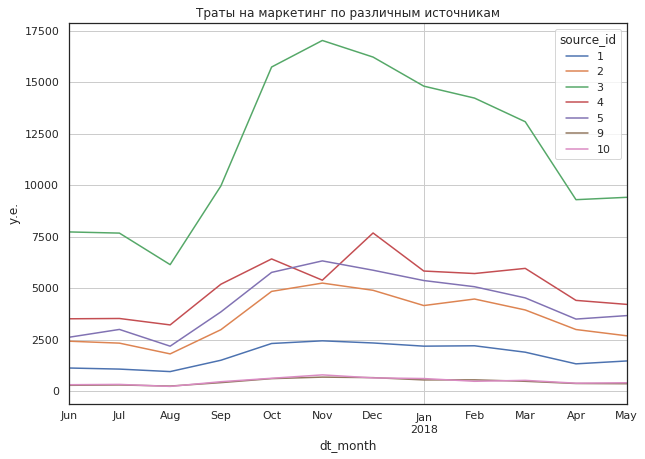

In [58]:
costs_plot = costs_data_pivot.plot(figsize=(10,7), title='Траты на маркетинг по различным источникам',grid=True)
costs_plot.set_ylabel('у.е.')
plt.show()

Самый дорогостоящий источник 3.
Самый дешёвый источник 10.
Но поведение графиков затрат на все источники подобны.

CAC (от англ. customer acquisition cost) — стоимость привлечения клиента. Сумма денег, во сколько обходится новый клиент компании.

In [59]:
cac_all = costs_data['costs'].sum() / orders_data['uid'].nunique()
print('Среднее значение CAC на одного покупателя для всего проекта', cac_all)

Среднее значение CAC на одного покупателя для всего проекта 9.011872843765401


In [60]:
# Суммарные затраты на различные источники привлечения
costs_grouped = costs_data.groupby('source_id')['costs'].sum()

In [61]:
# Первые визиты пользователей на сайт и то, как они попали туда, через какой источник
users_grouped = visits_data.sort_values(by=['uid','start_ts']).groupby('uid').agg({'source_id':'first','visit_month':'first'})

In [62]:
users_grouped = users_grouped.reset_index().rename(columns = {'visit_month':'month'})

In [63]:
# Пользователи, которые стали покупателями
buyers = users_grouped.query('uid in @orders_data.uid')
buyers = buyers.groupby('source_id').agg({'uid':'nunique'})

In [64]:
report_cac = buyers.merge(costs_grouped, on='source_id')
report_cac['cost_per_buyer'] = report_cac['costs'] / report_cac['uid']

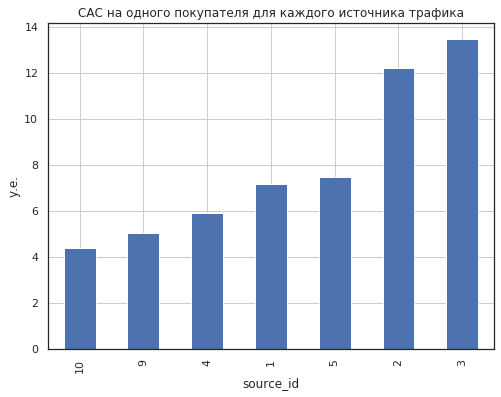

In [65]:
cac_plot = report_cac['cost_per_buyer'].sort_values().plot(kind = 'bar', figsize = (8,6), grid = True, 
                                                title = 'САС на одного покупателя для каждого источника трафика')
cac_plot.set_ylabel('y.e.')
plt.show()

Самый дешёвый и самый дорогой источники привлечения клиентов не отличаются от графика выше. А вот источник 2 оказался одинм из самых дорогостоящих.

ROMI по когортам в разрезе источников

ROMI (return on marketing investment) показывает окупаемость источников привлечения.

In [66]:
margin_rate = 1

Источник 1


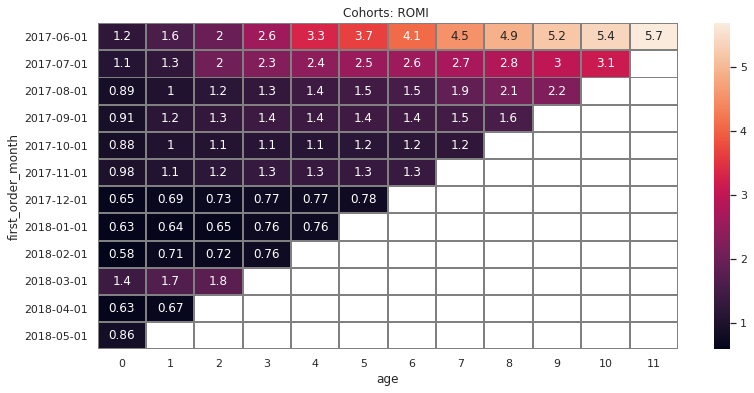

Источник 2


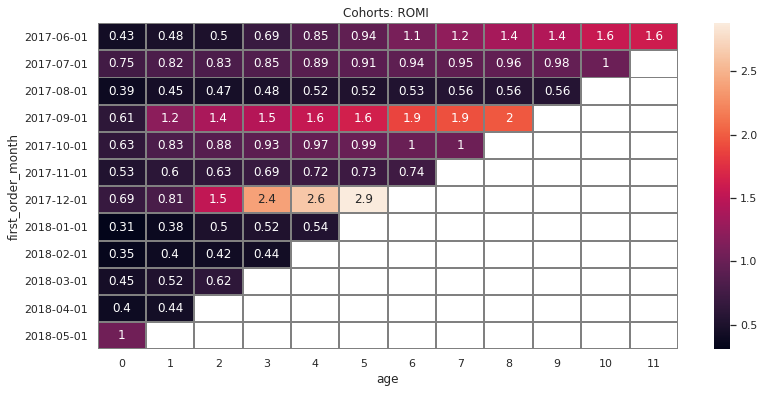

Источник 3


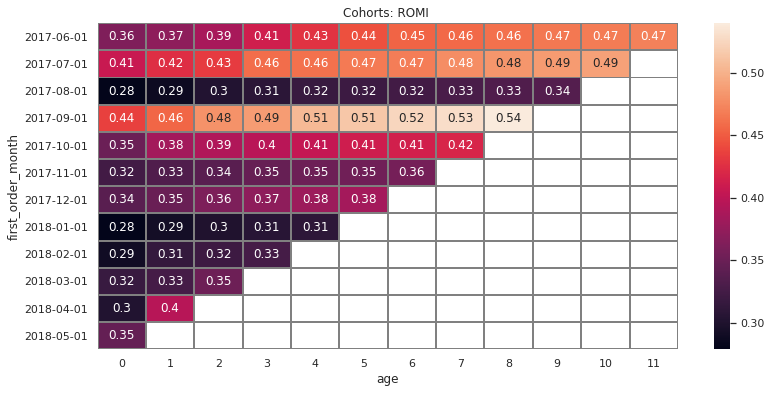

Источник 4


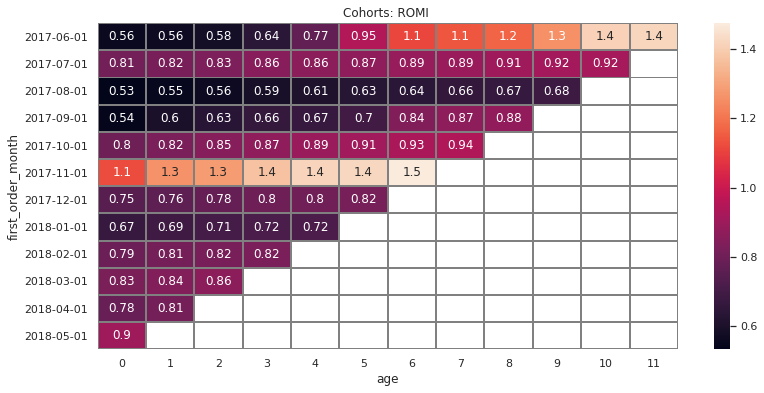

Источник 5


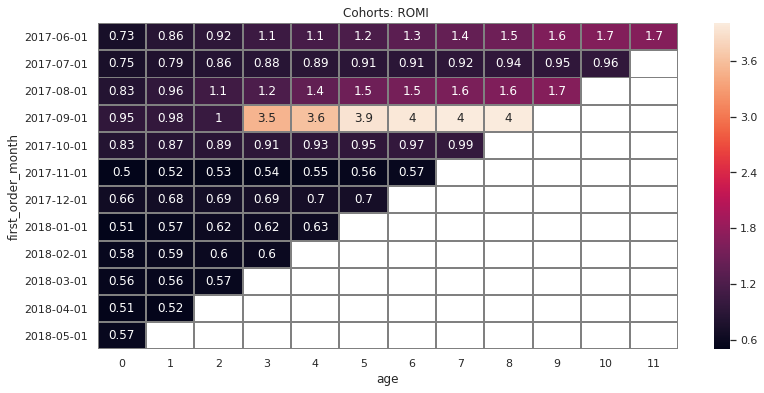

Источник 9


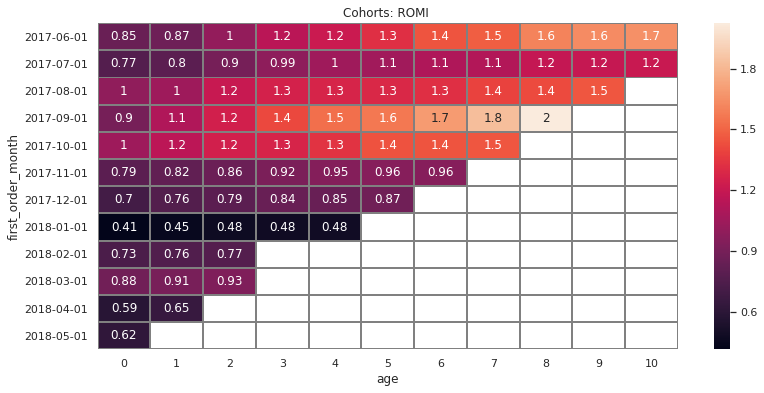

Источник 10


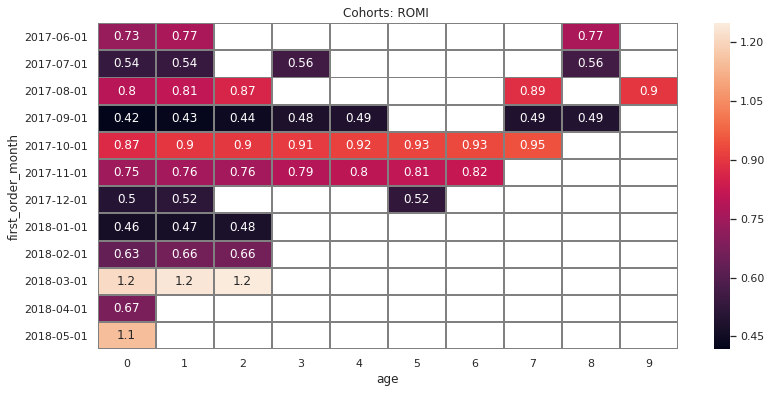

In [67]:
for source in [1,2,3,4,5,9,10]:
    users_grouped = visits_data.sort_values(by=['uid','start_ts']).groupby('uid').agg({'source_id':'first','visit_month':'first'})
    source_customers = users_grouped.query('source_id == @source').index.values
    source_orders = orders_data.query('uid in @source_customers')
    
    cohort_sizes = (
    source_orders.groupby('first_order_month')
    .agg({'uid': 'nunique'})
    .reset_index())
    cohort_sizes.columns = ['first_order_month', 'n_buyers']
    
    cohorts = (
    source_orders.groupby(['first_order_month', 'order_month'])
                    .agg({'revenue': 'sum'})
                    .reset_index())
    report_s_1 = pd.merge(cohort_sizes, cohorts, on='first_order_month')

    report_s_1['gp'] = report_s_1['revenue'] * margin_rate   # валовая прибыль
    report_s_1['age'] = (report_s_1['order_month'] - report_s_1['first_order_month']) / np.timedelta64(1, 'M')
    report_s_1['age'] = report_s_1['age'].round().astype('int')
    
    report_s_1['ltv'] = report_s_1['gp'] / report_s_1['n_buyers']
    output = report_s_1.pivot_table(
    index='first_order_month', columns='age', values='ltv', aggfunc='mean')
    output = output.cumsum(axis=1).fillna(0)
    
    source_costs = costs_data.query('source_id == @source')
    source_costs = source_costs.groupby('dt_month').agg({'costs':'sum'})
    source_costs = source_costs.join(cohort_sizes.set_index('first_order_month'))
    source_costs['cac'] = source_costs['costs'] / source_costs['n_buyers']
    report_new = pd.merge(
    report_s_1, source_costs, left_on='first_order_month', right_on='dt_month')
    report_new['romi'] = report_new['ltv']/report_new['cac']
    romi_pivot = report_new.pivot_table(index='first_order_month', columns='age', values='romi', aggfunc='mean')
    print('Источник', source)
    sns.set(style='white')
    plt.figure(figsize=(13, 6))
    plt.title('Cohorts: ROMI ') 
    romi_pivot.index = romi_pivot.index.astype('str')
    plot_sns = sns.heatmap(romi_pivot.cumsum(axis=1), annot=True,  linewidths=1, linecolor='gray')
    plt.show()


Наболее выгодным источником являетс 1 истояник, у него самые высокие показатели ROMI. Хуже всего себя показал 3 источник, они и самый дорогой, и показатели ROMI самые низкие. Остальные источники покахывают примерно одни и те же результаты.

### Общие выводы и рекомендации

<a id='step_5'></a>

Источники трафика, которые выглядят перспиктивными: 1,2,4 и 5. Затраты на них не самые высокие. Но и привлекают они достаточно покупателей, судя по тепловым диаграммам ROMI. 

Продуктовые: 
- количество визитов на сайт зависит от дня недели(когда люди начинают строить планы на выходные, например);
- летом люди реже заходят на сайт;
- люди проводят на сайте в среднем 1 минуту;
- от 2 до 7 процентов людей возвращаются на сайт.

Метрики электронной коммерции:
- между первой покупкой и первым посешением проходит примерно 2 дня;
- в среднем люди делают за полгода от 1 до 4 покупок;
- средний чек от 4 до 6 у.е;
- средний чек выше в декабре, июле, сентябрь, март;
- средний чек нижн в июне и январе.

Маркетинговые метрики:
- самый дорогой источник трафика 3;
- самый дешевый источник трафика 10;
- самый оптимальный источник трафика 1.

Самой перспективной когортой является первая (июнь 2017): её покупатели достаточно стаюильно возвращаются на сайт и совершают покупки.

Ещё интересноя является когорта сентября 2017 года. Она приносит достаточно высокую прибыль. Но со временем быстрее уменьшается. 